# Convolutional Neural Network

**Notes about this specific notebook**

Uses rgb, 64x64 images with ReLU activation and Adam optimizer. No class or sample specific weights are used. Same as cnn-kaggle-v021

# Changeable Parameters

_____________________________________________________________________

In [1]:
# Image size (height x width)
ih = 64
iw = 64

# Grayscale or RGB
ch = 'grayscale'

# Batch size
batch_size = 40000

# Number of epochs
epoch_t = 40

# Where computation is performed: Kaggle (0) or Local (1)
cenv = 1

# Division of the training vs. test set 
test_size = 0.3

# number of folds
n_folds = 10

_____________________________________________________________________

In [2]:
# To check whether the right environment has been selected
if cenv == 0:
    print("Computation environment: Kaggle")
if cenv == 1:
    print("Computation environment: Local")

Computation environment: Local


Import the necessary libraries

In [3]:
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
import tensorflow as tf
import numpy as np
from sklearn.utils import class_weight
from sklearn import metrics
import sys
import os
from math import log
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

Check whether a, and which GPU is available for the computation

In [4]:
is_cuda_gpu_available = tf.config.list_physical_devices('GPU')
print(is_cuda_gpu_available)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
# Image size
im_si = (ih, iw)

# Convert the color channel to the corresponding number of layers
if(ch == 'rgb'):
    chnum = 3
elif(ch == 'grayscale'):
    chnum = 1

Create new directory for saving output files if computation is done locally

In [6]:
if cenv == 1:
    file_exists = []
    vnum = 1
    dir = "C:/Users/Max/Documents/GitHub/malimg_dataset"
    for files in os.listdir(dir):
        if "cnn" in files:
            try:
                vnum = max(vnum, int(files[-3:]))
            except: 
                continue
            new_vnum = vnum + 1
            file_exists.append(True)
        else: 
            file_exists.append(False)
    # If this is the first notebook you want to save, a new folder will be created with version #001
    if sum(file_exists) == 0:
        new_vnum = 1
        print("No matches found")

    else: 
        print(f"{sum(file_exists)} matches(es) found")
        print("--------------")

    # Print new folder name
    print(f"New folder name: crossv-cgan-cnn-local-v{new_vnum:03}")
    print("--------------")
    
    # Create new folder with the name of the notebook and the version number
    new_dir = f"/Users/Max/Documents/GitHub/malimg_dataset/crossv-cgan-cnn-local-v{new_vnum:03}"
    os.makedirs(new_dir)

17 matches(es) found
--------------
New folder name: crossv-cgan-cnn-local-v021
--------------


**Data**


In [7]:
if cenv == 0:
    path_root = "/kaggle/input/malimgdataset"
    path_root_gen = '/kaggle/input/malimgcganlocalv009woallaple'

if cenv == 1:
    path_root = "C:/Users/Max/Documents/image_data/malimg_paper_dataset_imgs"
    path_root_gen = "C:/Users/Max/Documents/image_data/malimg-cgan-v025-rightsize"

Load the data. No data augmentation takes place

In [8]:
batches = ImageDataGenerator().flow_from_directory(
    directory     = path_root, 
    color_mode    = ch, 
    target_size   = (ih,iw), 
    batch_size    = batch_size,
    interpolation = 'bicubic'
)
imgs, labels = next(batches)

Found 9339 images belonging to 25 classes.


In [9]:
batches_gen = ImageDataGenerator().flow_from_directory(
    directory     = path_root_gen, 
    color_mode    = ch, 
    target_size   = (ih,iw), 
    batch_size    = batch_size,
    interpolation = 'bicubic'
)
imgs_gen, labels_gen = next(batches_gen)

Found 58507 images belonging to 25 classes.


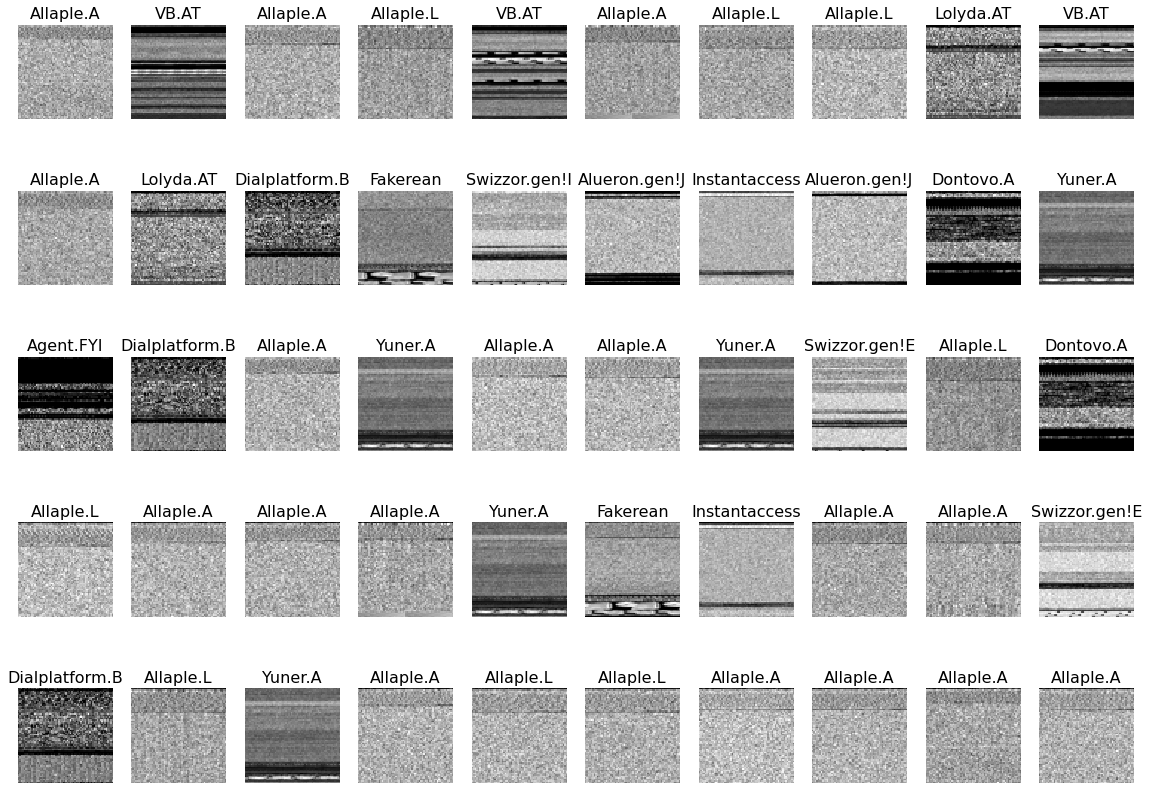

In [10]:
# plots images with labels within jupyter notebook
def plots(ims, figsize=(20,30), rows=10, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != chnum):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = 10 # len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(0,50):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(list(batches.class_indices.keys())[np.argmax(titles[i])], fontsize=16)
        plt.imshow(ims[i], cmap = 'gray',interpolation=None if interp else 'none')
        
plots(imgs, titles = labels)

In [11]:
# A dictionary of all the different classes
classes = batches.class_indices.keys()
x_axis = np.arange(len(list(classes)))

Plot data distribution among all classes

Standardize images

In [12]:
imgs = imgs / 255.0
imgs_gen = imgs_gen / 255.0

Plot data distribution among train, val. and test set

# Convolutional Neural Network
We will now build our **CNN** model using Keras. This model will have the following layers :

* **Convolutional Layer** : 30 filters, (3 * 3) kernel size
* **Max Pooling Layer** : (2 * 2) pool size
* **Convolutional Layer** : 15 filters, (3 * 3) kernel size
* **Max Pooling Layer** : (2 * 2) pool size
* **DropOut Layer** : Dropping 25% of neurons.
* **Flatten Layer**
* **Dense/Fully Connected Layer** : 128 Neurons, ReLU activation function
* **DropOut Layer** : Dropping 50% of neurons.
* **Dense/Fully Connected Layer** : 50 Neurons, Softmax activation function
* **Dense/Fully Connected Layer** : num_class Neurons, Softmax activation function

**Input shape** : 64 * 64 * 1

In [13]:
import keras
from keras.models import Sequential, Input, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import KFold
from tensorflow.keras.utils import to_categorical

In [14]:
from sklearn.metrics import f1_score, matthews_corrcoef, accuracy_score
from prettytable import PrettyTable, MSWORD_FRIENDLY

We want **11** classes

In [15]:
num_classes = len(list(batches.class_indices))
print("The number of classes in our dataset: ", num_classes)

The number of classes in our dataset:  25


Building the model

Reduce learning rate after 5 epochs of no improvement on the validition accuracy. Also save save checkpoints for the best performing model based on validation loss

In [16]:
def malware_model():
        Malware_model = Sequential()
        Malware_model.add(Conv2D(30, kernel_size=(3, 3),
                         activation='relu',
                         input_shape=(ih,iw,chnum)))

        Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
        Malware_model.add(Conv2D(15, (3, 3), activation='relu'))
        Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
        Malware_model.add(Dropout(0.25))
        Malware_model.add(Flatten())
        Malware_model.add(Dense(128, activation='relu'))
        Malware_model.add(Dropout(0.5))
        Malware_model.add(Dense(50, activation='relu'))
        Malware_model.add(Dense(num_classes, activation='softmax'))
        Malware_model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
        return Malware_model

In [17]:
def confusion_matrix(confusion_matrix, class_names_bin, figsize = (5,2), fontsize=7):

        df_cm = pd.DataFrame(
            confusion_matrix, index=class_names_bin, columns=class_names_bin, 
        )
        fig = plt.figure(figsize=figsize)
        try:
            heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
        except ValueError:
            raise ValueError("Confusion matrix values must be integers.")
        heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
        heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

class_names_bin= ("ransomware", "benign")

In [18]:
anne = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-4)
if cenv == 0:
    checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)
if cenv == 1:
    checkpoint = ModelCheckpoint(f'{new_dir}/model.h5', verbose=1, save_best_only=True)


In [19]:
# Performance metrics
multi_acc_per_fold = []
loss_per_fold = []
multi_f1_per_fold = []
bin_acc_per_fold = []
bin_tpr_per_fold = []
bin_f1_per_fold = []
bin_mcc_per_fold = []

tp = []
fp = []
fn = []
tn = []

y_pred = []
y_true = []

rw_count = []
bn_count = []

# History
history = []

# Data distribution
train_distr = []
test_distr= []

In [20]:
kfold = KFold(n_splits=n_folds, shuffle=True)

1513/1513 [==============================] - 11s 6ms/step - loss: 0.2009 - accuracy: 0.9221 - val_loss: 0.1935 - val_accuracy: 0.9518

Epoch 00001: val_loss improved from inf to 0.19346, saving model to /Users/Max/Documents/GitHub/malimg_dataset/crossv-cgan-cnn-local-v021\model.h5
Score for fold 1: loss of 0.19346438348293304; accuracy of 95.18201351165771%
1513/1513 [==============================] - 10s 6ms/step - loss: 0.2200 - accuracy: 0.9098 - val_loss: 0.2101 - val_accuracy: 0.9433

Epoch 00001: val_loss did not improve from 0.19346
Score for fold 2: loss of 0.2100885808467865; accuracy of 94.3254828453064%
1513/1513 [==============================] - 9s 6ms/step - loss: 0.2215 - accuracy: 0.9107 - val_loss: 0.2351 - val_accuracy: 0.9336

Epoch 00001: val_loss did not improve from 0.19346
Score for fold 3: loss of 0.2351388931274414; accuracy of 93.36188435554504%
1513/1513 [==============================] - 11s 7ms/step - loss: 0.2196 - accuracy: 0.9134 - val_loss: 0.1746 - val

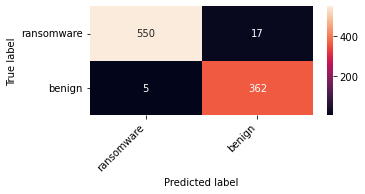

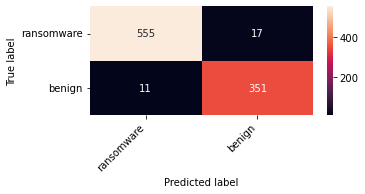

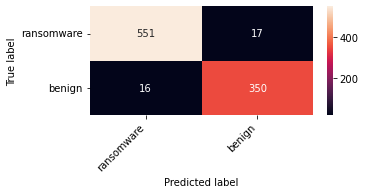

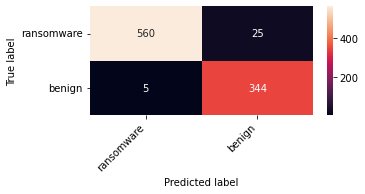

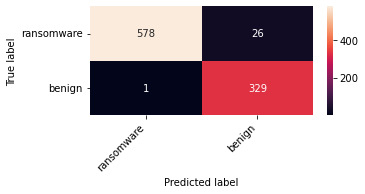

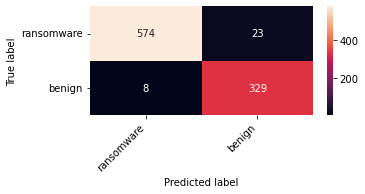

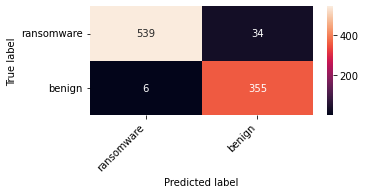

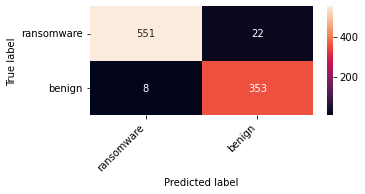

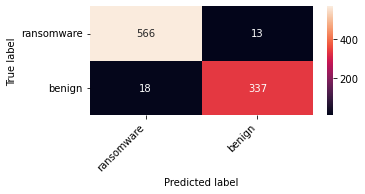

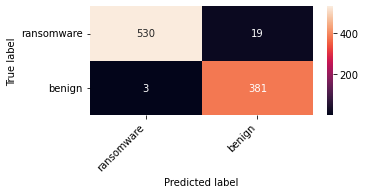

In [21]:
fold_no = 1

for train, test in kfold.split(imgs,labels):
    
    # Compile the CNN
    Malware_model = malware_model()
    
    # Add generated images to training data   
    train_images = np.concatenate((imgs[train], imgs_gen), axis = 0)
    train_labels = to_categorical(np.concatenate((np.argmax(labels[train], axis = 1), np.argmax(labels_gen, axis = 1)), axis = 0))
    
    # Include lower weights for CGAN data
    sample_weights1 = np.full(len(labels[train]), 1)
    sample_weights2 = np.full(len(labels_gen), 0.5)
    sample_weights = np.concatenate((sample_weights1, sample_weights2))

    # Run the CNN
    history.append(
        Malware_model.fit(
        train_images, 
        train_labels, 
        validation_data=(imgs[test], labels[test]), 
        epochs=epoch_t,
        sample_weight=sample_weights,
        callbacks = [anne, checkpoint]) # The actual computation of the CNN
    )
    
    # Generate generalization metrics
    scores = Malware_model.evaluate(imgs[test], labels[test], verbose=0)
    print(f'Score for fold {fold_no}: {Malware_model.metrics_names[0]} of {scores[0]}; {Malware_model.metrics_names[1]} of {scores[1]*100}%')
    multi_acc_per_fold.append(scores[1])
    loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no = fold_no + 1
    
    # Create two 1D-arrays: one with the prediction per image of the model and one with the true labels
    y_pred = np.append(y_pred, np.argmax(Malware_model.predict(imgs[test]), axis=-1))
    y_true = np.append(y_true, np.argmax(labels[test], axis=1))
    
    y_pred2 = np.argmax(Malware_model.predict(imgs[test]), axis=-1)
    y_true2 = np.argmax(labels[test], axis=1)
    
    # Binary
    y_predbin = [] 
    y_truebin = []
    for count, value in enumerate(y_true2):
        if y_true2[count] in range(10): # range(10) is 0 to 9, meaning all ransomware families
            y_truebin.append(0)
        else: y_truebin.append(1) # if prediction is not one of the ransomware families, then it is benign

        if y_pred2[count] in range(10): # range(10) is 0 to 9, meaning all ransomware families
            y_predbin.append(0)
        else: y_predbin.append(1) # if prediction is not one of the ransomware families, then it is benign
        continue
        
    rw_count.append(len(y_truebin) - np.sum(y_truebin))
    bn_count.append(np.sum(y_truebin))
    
    # Binary confusion Matrix
    c_matrix_bin = metrics.confusion_matrix(y_truebin, y_predbin)
    
    confusion_matrix(c_matrix_bin, class_names_bin, figsize = (5,2), fontsize=10)
    
    tp.append(c_matrix_bin[0,0])
    fp.append(c_matrix_bin[0,1])
    fn.append(c_matrix_bin[1,0])
    tn.append(c_matrix_bin[1,1])
    
    multi_f1_per_fold.append(f1_score(y_true2, y_pred2, average='macro'))
    bin_tpr_per_fold.append(c_matrix_bin[0,0]/(c_matrix_bin[0,0] + c_matrix_bin[0,1])) #True Positive Rate
    bin_acc_per_fold.append(accuracy_score(y_truebin, y_predbin)) # Accuracy
    bin_f1_per_fold.append(f1_score(y_truebin, y_predbin, labels=0)) # F1 Score
    bin_mcc_per_fold.append(matthews_corrcoef(y_truebin, y_predbin))  # Matthews Correlation Coefficient
    
    train_distr.append((sum(train_labels)/train_labels.shape[0])*100)
    test_distr.append((sum(labels[test])/labels[test].shape[0])*100)
    

In [22]:
(np.argmax(Malware_model.predict(imgs[test]), axis=-1))

array([20, 24,  2,  3, 16, 24, 22,  2, 24, 19,  7,  2, 24,  2,  2, 24, 12,
        2,  4,  2, 24,  2,  3,  2,  6, 24, 20, 14,  0,  2,  2, 22,  2,  2,
        2,  4, 11,  3,  2, 23, 22, 24, 10,  2, 24,  2, 24,  2,  6, 17,  2,
       22,  3,  3, 22, 12,  2, 11, 10,  3, 12,  4, 17,  1,  8,  3,  2, 11,
        4, 24, 12,  3,  3,  2, 18,  2,  3,  2, 10, 22,  2,  2, 10, 10, 10,
        2,  2, 11, 12,  3, 16, 21, 20,  0, 10,  2,  2,  3,  2,  3,  3,  0,
       20,  3,  2, 24,  0, 24, 24,  3,  2, 20, 11, 24, 11, 10,  3, 18, 12,
        2, 22,  3, 12,  2, 19, 22,  3, 24, 13, 10, 15,  2,  2,  4, 21, 10,
        2,  3,  2, 15,  7, 18,  2, 14, 23,  0,  3, 21, 24, 24, 12,  3,  3,
       12,  3, 12, 23, 24, 24, 24, 22, 24, 24, 12,  2, 24,  3, 11,  9, 13,
        3,  9,  3,  2,  3,  3,  3, 24,  2, 11,  2,  2,  9, 12, 24,  8,  3,
        2, 10, 11, 18, 17,  3,  3,  2,  3, 15,  3,  2,  8, 23,  8,  2,  2,
        2,  7,  3,  8,  2, 21,  3, 17, 15, 24,  7, 24,  2,  3,  2,  3, 12,
        2, 22, 24,  2,  3

Run the model

In [23]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(multi_acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {multi_acc_per_fold[i]*100}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(multi_acc_per_fold)*100}% (+- {np.std(multi_acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.19346438348293304 - Accuracy: 95.18201351165771%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.2100885808467865 - Accuracy: 94.3254828453064%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.2351388931274414 - Accuracy: 93.36188435554504%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.1745968759059906 - Accuracy: 94.75374817848206%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.19030998647212982 - Accuracy: 93.7901496887207%
------------------------------------------------------------------------
> Fold 6 - Loss: 0.17001695930957794 - Accuracy: 94.3254828453064%
------------------------------------------------------------------------

# Evaluating performance

Create data distribution graph

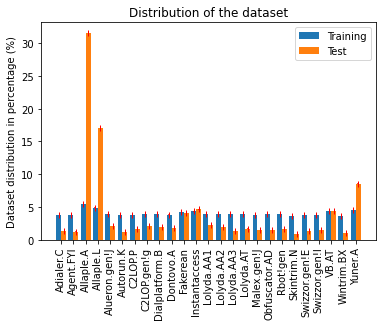

In [24]:
perc_train = np.mean(train_distr, axis = 0)
perc_test =  np.mean(test_distr, axis = 0)

plt.bar(x_axis - 0.2, perc_train, 0.4, label = 'Training')
plt.errorbar(x_axis - 0.2, perc_train, yerr = np.std(train_distr, axis = 0), 
             fmt='|', color='red', capsize = 0)

plt.bar(x_axis + 0.2, perc_test,0.4, label = 'Test')
plt.errorbar(x_axis + 0.2, perc_test, yerr = np.std(train_distr, axis = 0), 
             fmt='|', color='red', capsize=0.0)


plt.title('Distribution of the dataset')
plt.ylabel('Dataset distribution in percentage (%)')
plt.xticks(x_axis, list(classes), rotation='vertical')
plt.legend()

if cenv == 0:
    plt.savefig("multi_data_dist.png", bbox_inches = 'tight', dpi = 150)
if cenv == 1:
    plt.savefig(f"{new_dir}/multi_data_dist.png", bbox_inches = 'tight', dpi = 150)

In [25]:
t = PrettyTable(['Metric', 'Performance', 'St.Deviation'])
t.add_row(['M-Class', "", ""])
t.add_row(['Acc    ', round(np.mean(multi_acc_per_fold),4), round(np.std(multi_acc_per_fold),4)])
t.add_row(['Loss   ', round(np.mean(loss_per_fold),4), round(np.std(loss_per_fold),4)])
t.add_row(['Macro F1', round(np.mean(multi_f1_per_fold), 4), round(np.std(multi_f1_per_fold),4)])
t.border = True
t.add_row(['', '', ''])
t.add_row(['B-Class', "", ""])
t.add_row(['TPR    ', round(np.mean(bin_tpr_per_fold),4), round(np.std(bin_tpr_per_fold),4)])
t.add_row(['Acc    ', round(np.mean(bin_acc_per_fold),4), round(np.std(bin_acc_per_fold),4)])
t.add_row(['F1     ', round(np.mean(bin_f1_per_fold),4), round(np.std(bin_f1_per_fold),4)])
t.add_row(['MCC    ', round(np.mean(bin_mcc_per_fold),4), round(np.std(bin_mcc_per_fold),4)])
t.header = True
t.set_style(MSWORD_FRIENDLY)
t.align = "l"
t.title = "Performance of CNN"
print(t)

+---------------------------------------+
|           Performance of CNN          |
| Metric   | Performance | St.Deviation |
| M-Class  |             |              |
| Acc      | 0.9422      | 0.006        |
| Loss     | 0.1926      | 0.0211       |
| Macro F1 | 0.841       | 0.015        |
|          |             |              |
| B-Class  |             |              |
| TPR      | 0.9631      | 0.0097       |
| Acc      | 0.9685      | 0.0053       |
| F1       | 0.9595      | 0.0071       |
| MCC      | 0.9344      | 0.0111       |


In [26]:
# Saving PrettyTable
table = t.get_string()

if cenv == 0:
    with open('multi_performance_table.txt', 'w') as f:
        f.write(table)
if cenv == 1:
    with open(f'{new_dir}/multi_performance_table.txt', 'w') as f:
        f.write(table)

Evaluate the model based on the test set

Save a table with the performance on the test set

**Evaluating overfitting and other model performance measures**

In [27]:
linecolours = ['gray', 'orange', 'blue', 'green','silver', 'cyan', 'red', 'purple', 'lightgreen', 'black', 'brown']

In [28]:
def eval_metric(model, history, metric_name, ymin, ymax):
    '''
    Function to evaluate a trained model on a chosen metric. 
    Training and validation metric are plotted in a
    line chart for each epoch.
    
    Parameters:
        history : model training history
        metric_name : loss or accuracy
    Output:
        line chart with epochs of x-axis and metric on
        y-axis
    '''
    for i in range(n_folds-1):  
        metric = history[i].history[metric_name]
        val_metric = history[i].history['val_' + metric_name]
        e = range(1, epoch_t + 1)
        plt.plot(e, metric, marker = 'o', linestyle = 'none', color = linecolours[i])
        plt.plot(e, val_metric, color = linecolours[i])
        
    metric = history[n_folds-1].history[metric_name]
    val_metric = history[n_folds-1].history['val_' + metric_name]
    e = range(1, epoch_t + 1)
    plt.plot(e, metric, marker = 'o', linestyle = 'none', label = 'Training', color = linecolours[n_folds-1])
    plt.plot(e, val_metric, label = 'Validation', color = linecolours[n_folds-1])
    
    plt.ylim(ymin, ymax)
    
    plt.xlabel('Epoch number')
    plt.ylabel(metric_name)
    plt.title('Comparing training and validation ' + metric_name + ' for CNN across folds')
    plt.legend()
    if cenv == 0:
        plt.savefig(f"cnn_model_{metric_name}.png", bbox_inches = 'tight', dpi = 150)
    if cenv == 1:
        plt.savefig(f"{new_dir}/cnn_model_{metric_name}.png", bbox_inches = 'tight', dpi = 150)

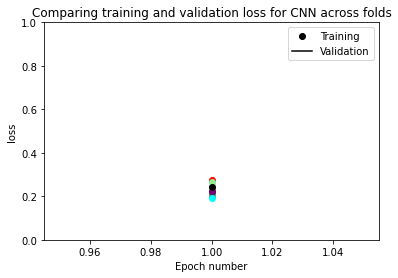

In [29]:
eval_metric(Malware_model, history, 'loss', 0,1)

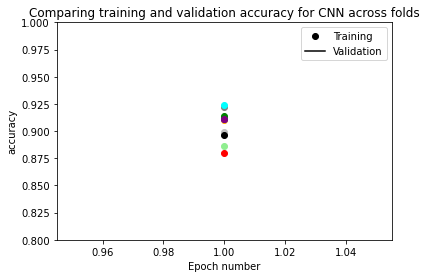

In [30]:
eval_metric(Malware_model, history, 'accuracy', 0.8,1)

# Confusion Matrix
Analysing the results

# Binary classification
y_predbin and y_testbin are the binary classification arrays. 0 = ransomware and 1 = benign

Plot the distribution of dataset as ransomware - benign

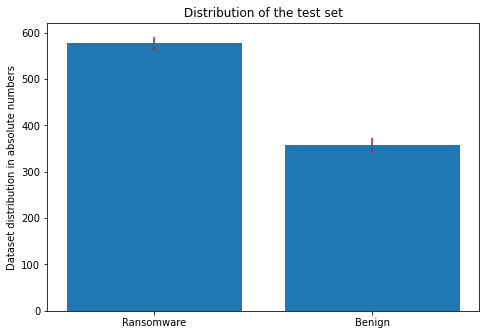

In [31]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
x_lab = ['Ransomware', 'Benign']
y_lab = [np.mean(rw_count), np.mean(bn_count)]
plt.title('Distribution of the test set')
plt.ylabel('Dataset distribution in absolute numbers')
ax.bar(x_lab, y_lab)
ax.errorbar(x_lab, y_lab, yerr = [np.std(rw_count), np.std(bn_count)], fmt = '|', ecolor='red')
if cenv == 0:
    plt.savefig("bin_data_dist.png", bbox_inches = 'tight', dpi = 150)
if cenv == 1:
    plt.savefig(f"{new_dir}/bin_data_dist.png", bbox_inches = 'tight', dpi = 150)

Plot binary confusion matrix

In [32]:
all_y_predbin = [] 
all_y_truebin = []
for count, value in enumerate(y_true):
    if y_true[count] in range(10): # range(10) is 0 to 9, meaning all ransomware families
        all_y_truebin.append(0)
    else: all_y_truebin.append(1) # if prediction is not one of the ransomware families, then it is benign

    if y_pred[count] in range(10): # range(10) is 0 to 9, meaning all ransomware families
        all_y_predbin.append(0)
    else: all_y_predbin.append(1) # if prediction is not one of the ransomware families, then it is benign
    continue

In [33]:
def confusion_matrix_bin(confusion_matrix, class_names_bin, name, figsize = (5,2), fontsize=7):
   
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names_bin, columns=class_names_bin, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title(f"{(name.capitalize())} Confusion Matrix - CNN")
    if cenv == 0:
        plt.savefig(f"{name}_cmatrix.png", bbox_inches = 'tight', dpi = 150)
    if cenv == 1:
        plt.savefig(f"{new_dir}/{name}_cmatrix.png", bbox_inches = 'tight', dpi = 150)

In [34]:
c_matrix_bin = metrics.confusion_matrix(all_y_truebin, all_y_predbin)

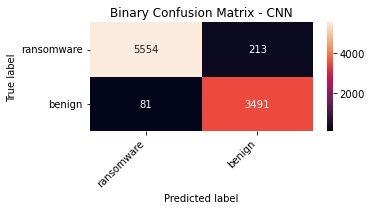

In [35]:
class_names_bin= ("ransomware", "benign")
confusion_matrix_bin(c_matrix_bin, class_names_bin, 'binary', figsize = (5,2), fontsize=10)

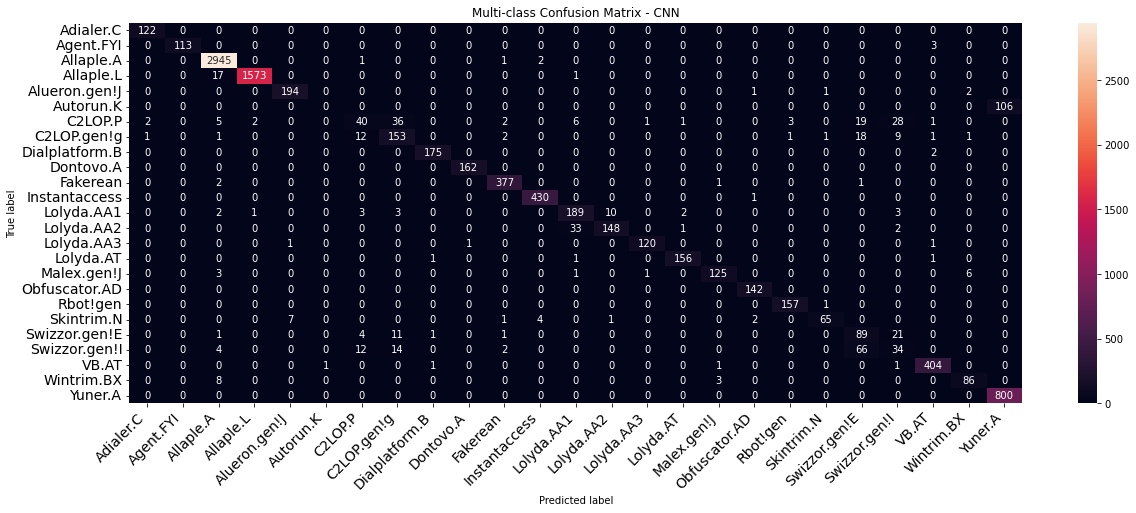

In [36]:
c_matrix = metrics.confusion_matrix(y_true, y_pred)
class_names= batches.class_indices.keys()
confusion_matrix_bin(c_matrix, class_names, 'multi-class', figsize = (20,7), fontsize=14)